In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
import itertools
%matplotlib inline

## Algorithms

In [2]:
# GDA

def GDA_step(x, y, out_f, out_g, eta=None):
    df_dx = torch.autograd.grad(outputs=out_f, inputs=x, create_graph=False)[0]
    dg_dy = torch.autograd.grad(outputs=out_g, inputs=y, create_graph=False)[0]
    return df_dx, dg_dy


# CGD

def CGD_step(x, y, out_f, out_g, eta):
    df_dx = torch.autograd.grad(outputs=out_f, inputs=x, create_graph=True)[0]
    dg_dy = torch.autograd.grad(outputs=out_g, inputs=y, create_graph=True)[0]

    d2f_dxdy = torch.autograd.grad(outputs=df_dx, inputs=y, create_graph=False, allow_unused=True)[0]
    d2g_dydx = torch.autograd.grad(outputs=dg_dy, inputs=x, create_graph=False, allow_unused=True)[0]

    if d2f_dxdy is None:
        d2f_dxdy = 0.

    if d2g_dydx is None:
        d2g_dydx = 0.

    step_x = ((1. / (1. - (eta ** 2.) * d2f_dxdy * d2g_dydx)) * (df_dx - eta * d2f_dxdy * dg_dy))
    step_y = ((1. / (1. - (eta ** 2.) * d2g_dydx * d2f_dxdy)) * (dg_dy - eta * d2g_dydx * df_dx))

    return step_x, step_y


# LCGD (LOLA)

def LCGD_step(x, y, out_f, out_g, eta):
    df_dx = torch.autograd.grad(outputs=out_f, inputs=x, create_graph=True)[0]
    dg_dy = torch.autograd.grad(outputs=out_g, inputs=y, create_graph=True)[0]

    d2f_dxdy = torch.autograd.grad(outputs=df_dx, inputs=y, create_graph=False, allow_unused=True)[0]
    d2g_dydx = torch.autograd.grad(outputs=dg_dy, inputs=x, create_graph=False, allow_unused=True)[0]

    if d2f_dxdy is None:
        d2f_dxdy = 0.

    if d2g_dydx is None:
        d2g_dydx = 0.

    step_x = (df_dx - eta * d2f_dxdy * dg_dy)
    step_y = (dg_dy - eta * d2g_dydx * df_dx)

    return step_x, step_y

# OGDA

def OGDA_step(x, y, out_f, out_g, eta):
    df_dx = torch.autograd.grad(outputs=out_f, inputs=x, create_graph=True)[0]
    dg_dy = torch.autograd.grad(outputs=out_g, inputs=y, create_graph=True)[0]

    d2f_dx2, d2f_dxdy = torch.autograd.grad(outputs=df_dx, inputs=[x, y], create_graph=False, allow_unused=True)
    d2g_dydx, d2g_dy2 = torch.autograd.grad(outputs=dg_dy, inputs=[x, y], create_graph=False, allow_unused=True)

    if d2f_dxdy is None:
        d2f_dxdy = 0.

    if d2g_dydx is None:
        d2g_dydx = 0.

    if d2f_dx2 is None:
        d2f_dx2 = 0.

    if d2g_dy2 is None:
        d2g_dy2 = 0.

    step_x = (df_dx - eta * d2f_dxdy * dg_dy - eta * d2f_dx2 * df_dx)
    step_y = (dg_dy - eta * d2g_dydx * df_dx - eta * d2g_dy2 * dg_dy)

    return step_x, step_y

# ConOPT

def ConOPT_step(x, y, out_f, out_g, eta):
    gamma = 1.

    df_dx = torch.autograd.grad(outputs=out_f, inputs=x, create_graph=True)[0]
    dg_dy = torch.autograd.grad(outputs=out_g, inputs=y, create_graph=True)[0]

    d2f_dx2, d2f_dxdy = torch.autograd.grad(outputs=df_dx, inputs=[x, y], create_graph=False, allow_unused=True)
    d2g_dydx, d2g_dy2 = torch.autograd.grad(outputs=dg_dy, inputs=[x, y], create_graph=False, allow_unused=True)

    if d2f_dxdy is None:
        d2f_dxdy = 0.

    if d2g_dydx is None:
        d2g_dydx = 0.

    if d2f_dx2 is None:
        d2f_dx2 = 0.

    if d2g_dy2 is None:
        d2g_dy2 = 0.

    step_x = (df_dx - gamma * d2f_dxdy * dg_dy + gamma * d2f_dx2 * df_dx)
    step_y = (dg_dy - gamma * d2g_dydx * df_dx + gamma * d2g_dy2 * dg_dy)

    return step_x, step_y


# Execution loops

def run_experiment(alg_names, alg_updates, experiments, x_init, y_init, f, g, n_updates):

    recorder = {alg_name: {f'alpha={alpha:.1f}, lr={lr:.2f}': [[x_init, y_init]] for alpha, lr in experiments} for alg_name in alg_names}
    for alg_name, alg_update in zip(alg_names, alg_updates):
        for (alpha, lr) in experiments:

            x = torch.tensor([x_init], requires_grad=True, dtype=torch.float64)
            y = torch.tensor([y_init], requires_grad=True, dtype=torch.float64)

            for i in range(n_updates):
                step_x, step_y = alg_update(x=x, y=y, out_f=f(x, y, alpha), out_g=g(x, y, alpha), eta=lr)
                x = x - lr * step_x
                y = y - lr * step_y

                recorder[alg_name][f'alpha={alpha:.1f}, lr={lr:.2f}'].append([x.data, y.data])

    return recorder

## Experiment 1

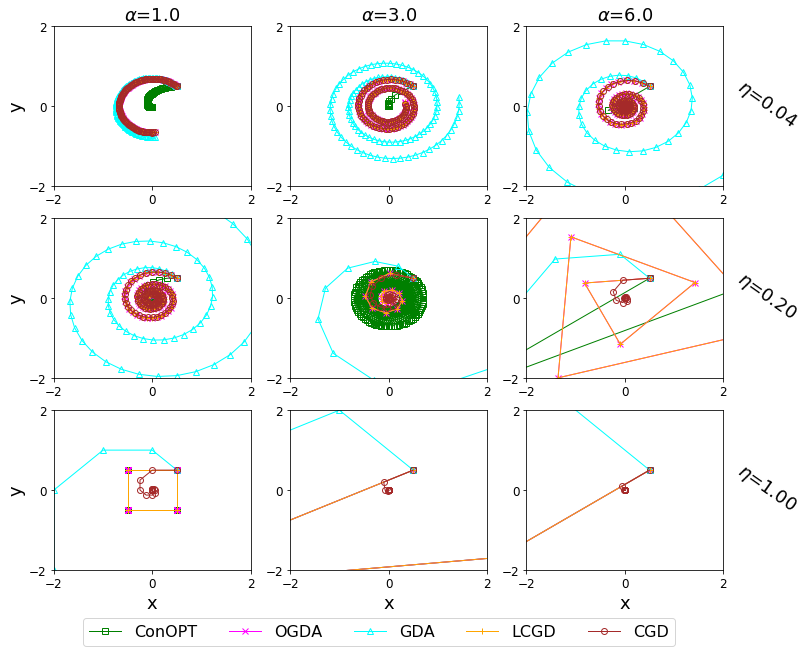

In [3]:
def f1(x, y, alpha):
    return alpha * x * y


def g1(*f_args):
    return - f1(*f_args)

x_init = 0.5
y_init = 0.5

alphas = [1., 3., 6.]
learning_rates = [0.04, 0.2, 1.]
experiments = list(itertools.product(alphas, learning_rates))

n_updates = 100

alg_names = ['ConOPT', 'OGDA', 'GDA', 'LCGD', 'CGD']
alg_updates = [ConOPT_step, OGDA_step, GDA_step, LCGD_step, CGD_step]
colors = ['green', 'magenta', 'cyan', 'orange', 'brown']
markers = ['s', 'x', '^', '+', 'o']

recorder = run_experiment(alg_names, alg_updates, experiments, x_init, y_init, f1, g1, n_updates)

# Plotting

fig, axes = plt.subplots(3, 3, figsize=(12, 10))
for (j,i), (alpha, lr) in zip(itertools.product(range(3), range(3)), experiments):

    for alg_name, color, marker in zip(alg_names, colors, markers):
        x_s, y_s = np.array(recorder[alg_name][f'alpha={alpha:.1f}, lr={lr:.2f}']).T
        axes[i,j].plot(x_s, y_s, marker=marker, color=color, fillstyle='none', linewidth=1, label=alg_name)

    if i == 0:
        axes[i, j].set_title(rf'$\alpha$={alpha:.1f}', fontsize=18)
    if j == 2:
        axes[i, j].text(s=rf'$\eta$={lr:.2f}', rotation=-35, x=2.2, y=-0.5, fontsize=18)
    if i == 2:
        axes[i, j].set_xlabel('x', fontsize=18)
    if j == 0:
        axes[i, j].set_ylabel('y', fontsize=18)
    axes[i, j].set_xlim(-2, 2)
    axes[i, j].set_ylim(-2, 2)
    axes[i, j].tick_params(axis='both', which='major', labelsize=12)
    axes[i, j].locator_params('x', nbins=3)
    axes[i, j].locator_params('y', nbins=3)
    if i == 2 and j == 2:
        axes[i, j].legend(loc='upper center', bbox_to_anchor=(-0.75, -0.25), fancybox=True, ncol=5, prop={'size': 16})

plt.show()
fig.savefig(f'experiment1.png', dpi=400)
plt.close(fig)

# Experiment 2

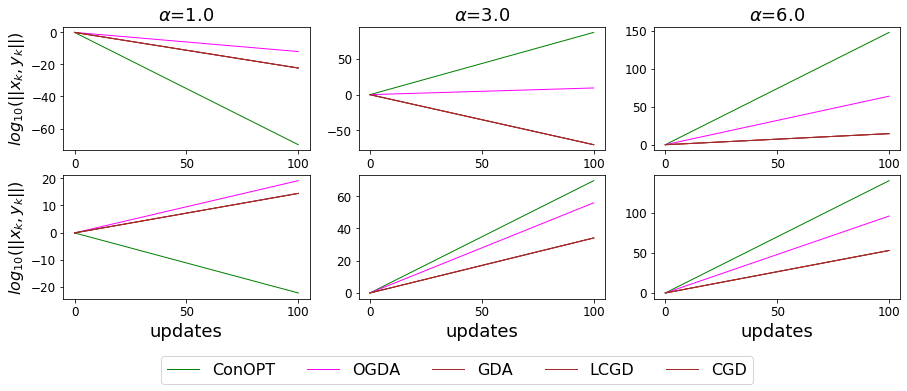

In [4]:
def f2(x, y, alpha):
    return alpha * (x ** 2 - y ** 2)


def g2(*f_args):
    return - f2(*f_args)


def f3(x, y, alpha):
    return alpha * (-x ** 2 + y ** 2)


def g3(*f_args):
    return - f3(*f_args)


x_init = 0.5
y_init = 0.5

alphas = [1., 3., 6.]
learning_rates = [0.2]
experiments = list(itertools.product(alphas, learning_rates))

n_updates = 100

alg_names = ['ConOPT', 'OGDA', 'GDA', 'LCGD', 'CGD']
alg_updates = [ConOPT_step, OGDA_step, GDA_step, LCGD_step, CGD_step]
# colors = ['cyan', 'cyan', 'cyan', 'green', 'orange']  # paper's color-mapping
colors = ['green', 'magenta', 'brown', 'brown', 'brown']

recorder2 = run_experiment(alg_names, alg_updates, experiments, x_init, y_init, f2, g2, n_updates)
recorder3 = run_experiment(alg_names, alg_updates, experiments, x_init, y_init, f3, g3, n_updates)

# Plotting

fig, axes = plt.subplots(2, 3, figsize=(15, 5))
for i, recorder in enumerate([recorder2, recorder3]):
    for j, (alpha, lr) in enumerate(experiments):

        for alg_name, color in zip(alg_names, colors):
            x_s, y_s = np.array(recorder[alg_name][f'alpha={alpha:.1f}, lr={lr:.2f}']).T
            axes[i,j].plot(np.log10(np.linalg.norm(np.array([x_s, y_s]), axis=0)), color=color, linewidth=1, label=alg_name)

        if i == 0:
            axes[i,j].set_title(rf'$\alpha$={alpha:.1f}', fontsize=18)
        if i == 1:
            axes[i,j].set_xlabel('updates', fontsize=18)

        if j == 0:
            axes[i,j].set_ylabel(r'$log_{10}(||x_k, y_k||)$', fontsize=16, rotation=90)

        axes[i,j].tick_params(axis='both', which='major', labelsize=12)
        axes[i,j].locator_params('x', nbins=3)
        axes[i,j].locator_params('y', nbins=5)
        if i == 1 and j == 2:
            legend = axes[i, j].legend(loc='upper center', bbox_to_anchor=(-0.8, -0.4), fancybox=True, ncol=5, prop={'size': 16})

plt.show()
fig.savefig(f'experiment2.png', bbox_extra_artists=(legend,), bbox_inches='tight', dpi=400)
plt.close(fig)